In [63]:
# Imports
import pandas as pd
import numpy as np
from __future__ import print_function

%matplotlib inline

#ignore warnings
#import warnings
#warnings.filterwarnings('ignore')

#Read in raw data
schoolData = pd.read_csv('D:/BenepactLLC/Belk/NC_Report_Card_Data/Summary Data Files/All_Data_By_School_Final.csv'
                         , low_memory=False)
testScores = pd.read_csv('D:/BenepactLLC/Belk/NC_Report_Card_Data/Summary Data Files/1516_Test_Scores.csv', low_memory=False)

#Review raw data before the join
schoolData.info()

#join files using school / unit code
schoolData = schoolData.merge(testScores, on='unit_code', how='left', suffixes=('_schoolData', '_testScores'))

#Review raw data after the join to make sure new fields were added
print('************************************************************')
schoolData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2579 entries, 0 to 2578
Columns: 293 entries, Year to State_Prin_Exp_Pct_10+_Years
dtypes: float64(255), int64(17), object(21)
memory usage: 5.8+ MB
************************************************************
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2579 entries, 0 to 2578
Columns: 365 entries, Year to Passing_Math_III
dtypes: float64(324), int64(17), object(24)
memory usage: 7.2+ MB


In [64]:
#Remove fields not needed for machine learning
excludeFields = ['Year','unit_code_schoolData', 'street_ad','scity_ad','state_ad','szip_ad','Closed_Ind_Text','New_ind_Txt',
                 'grades_BYOD','grades_1_to_1_access','District Name','unit_code_testScores','School Name','SBE District']

keepFields = [col for col in schoolData.columns if col not in excludeFields]

schoolData = schoolData[keepFields]

schoolData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2579 entries, 0 to 2578
Columns: 353 entries, unit_code to Passing_Math_III
dtypes: float64(324), int64(15), object(14)
memory usage: 7.0+ MB


In [65]:
#Clean up the dataset for machine learning 
boolFields = ['title1_type_flg', 'clp_ind_flg', 'focus_clp_flg', 'summer_program_flg', 
              'asm_no_spg_flg', 'no_data_spg_flg', 'stem_flg']

# Map flag fields into bool 
schoolData['title1_type_flg'] = schoolData['title1_type_flg'].map({-1:True, 0:False})
schoolData['clp_ind_flg'] = schoolData['clp_ind_flg'].map({-1:True, 0:False})
schoolData['focus_clp_flg'] = schoolData['focus_clp_flg'].map({-1:True, 0:False})
schoolData['summer_program_flg'] = schoolData['summer_program_flg'].map({-1:True, 0:False})
schoolData['asm_no_spg_flg'] = schoolData['asm_no_spg_flg'].map({-1:True, 0:False})
schoolData['no_data_spg_flg'] = schoolData['no_data_spg_flg'].map({-1:True, 0:False})
schoolData['stem_flg'] = schoolData['stem_flg'].map({-1:True, 0:False})

#
schoolData['esea_status'] = schoolData['esea_status'].map({'P':'Esea_Pass', 'F':'Esea_Fail', np.nan:'Non_Esea'})
schoolData['Grad_project_status'] = schoolData['Grad_project_status'].map({'Y':True, 'N':False, np.nan:False})

In [49]:
# Find all the categorical variables
schoolData_Bool = schoolData.loc[:, schoolData.dtypes == bool]
schoolData_Vars = schoolData.loc[:, schoolData.dtypes == object]
cat_list_obj = list(pd.concat([schoolData_Vars, schoolData_Bool]))
cat_list_obj_len = len(cat_list_obj) # number of object attributes
print("Number of Categorical Attributes = ", cat_list_obj_len)
cat_list_obj

Number of Categorical Attributes =  20


['1_to_1_access',
 'Byod',
 'EVAAS Growth Status',
 'Grad_project_status',
 'Math SPG Grade',
 'Reading SPG Grade',
 'SPG Grade',
 'State Gap Compared',
 'asm_no_spg_flg',
 'calendar_only_txt',
 'category_cd',
 'clp_ind_flg',
 'esea_status',
 'focus_clp_flg',
 'no_data_spg_flg',
 'school_type_txt',
 'stem_flg',
 'summer_program_flg',
 'title1_type_flg',
 'type_cd_txt']

In [50]:
#Review individual data types after data preparation
schoolData.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2579 entries, 0 to 2578
Data columns (total 352 columns):
type_cd_txt                                       object
category_cd                                       object
school_type_txt                                   object
calendar_only_txt                                 object
title1_type_flg                                   bool
clp_ind_flg                                       bool
focus_clp_flg                                     bool
summer_program_flg                                bool
asm_no_spg_flg                                    bool
no_data_spg_flg                                   bool
esea_status                                       object
student_num                                       float64
lea_avg_student_num                               float64
st_avg_student_num                                int64
Grad_project_status                               bool
stem_flg                                          

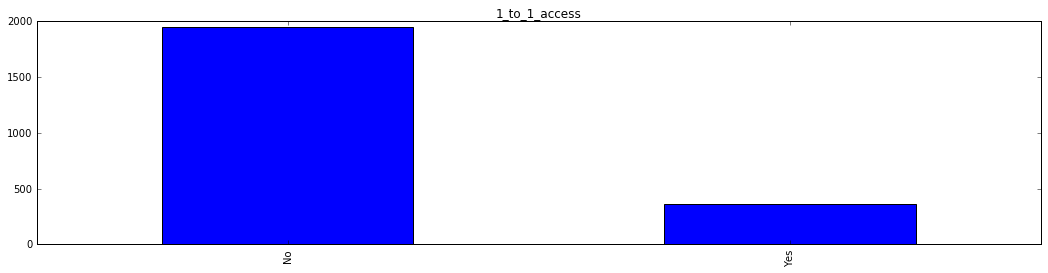

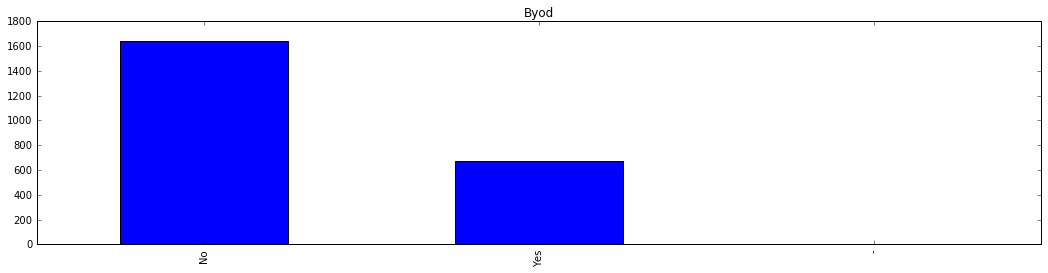

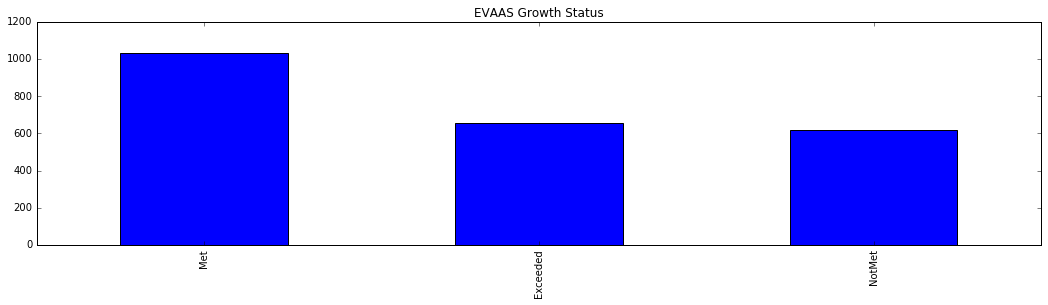

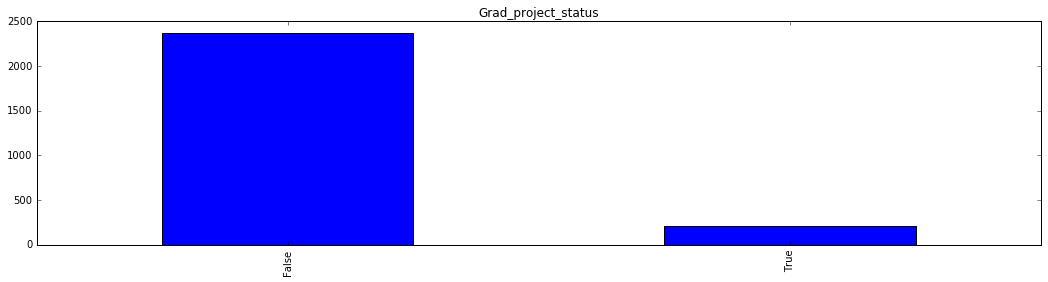

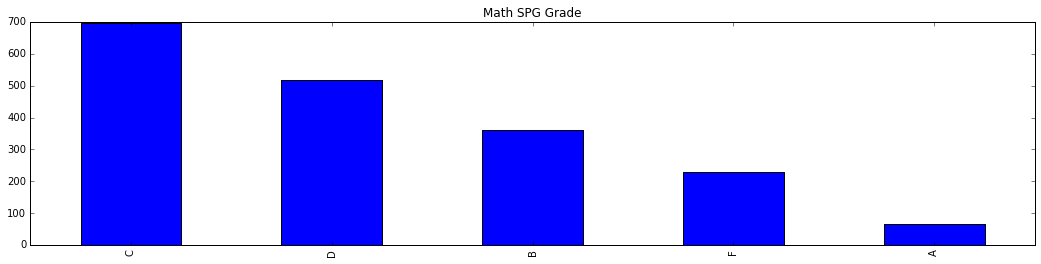

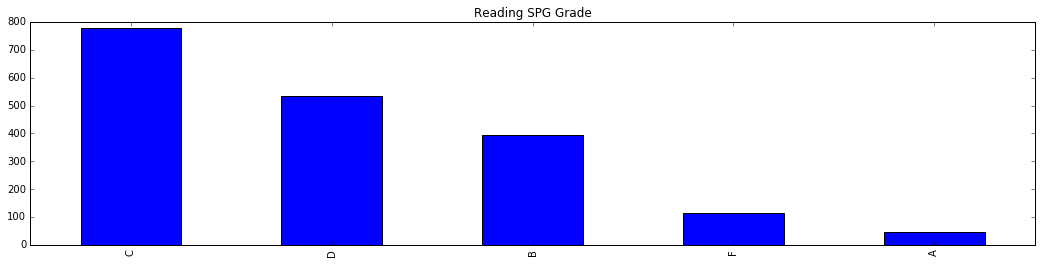

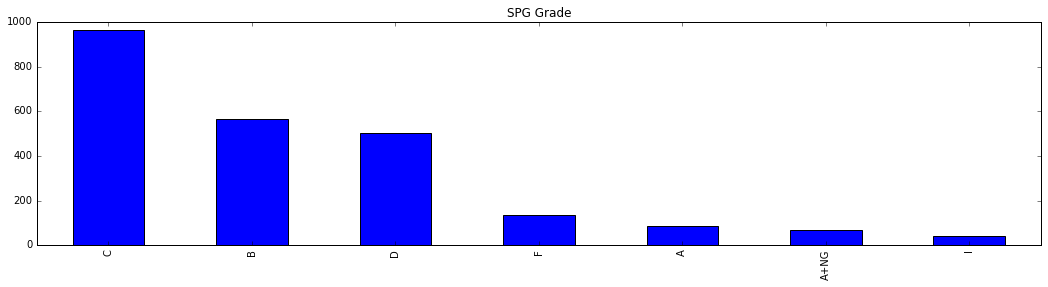

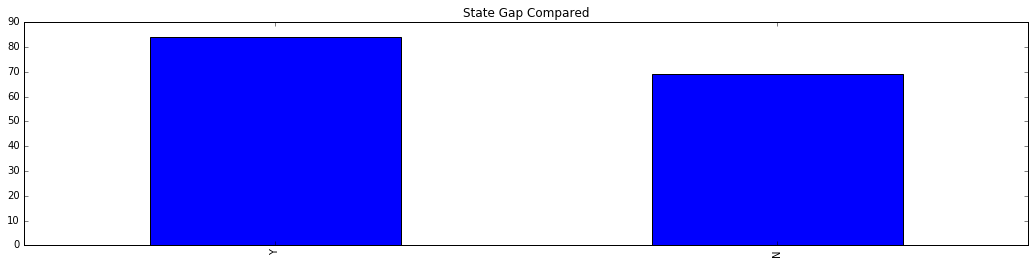

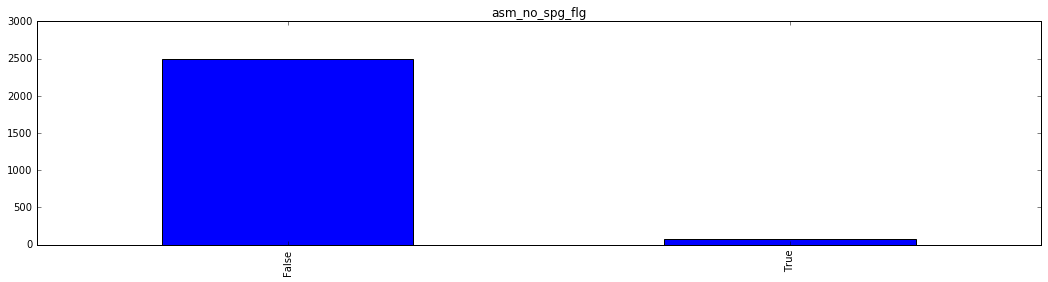

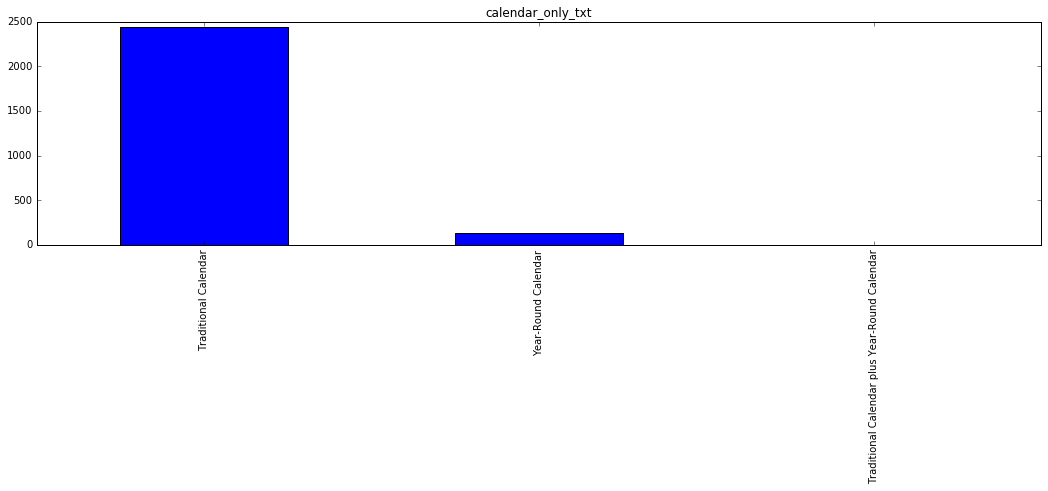

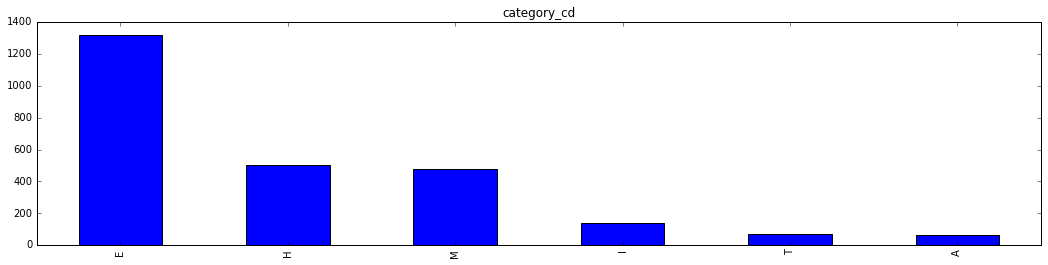

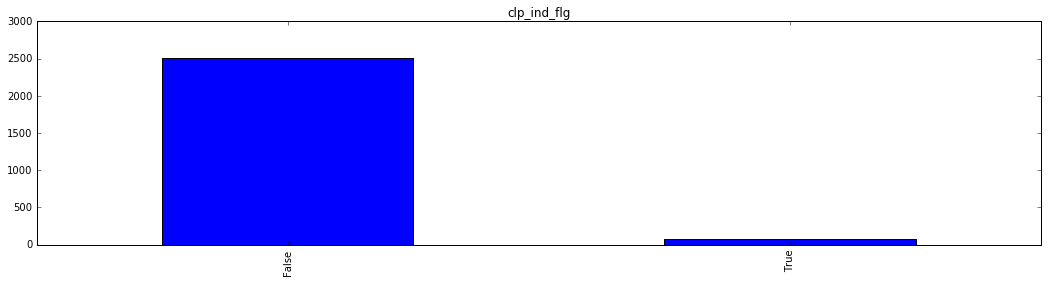

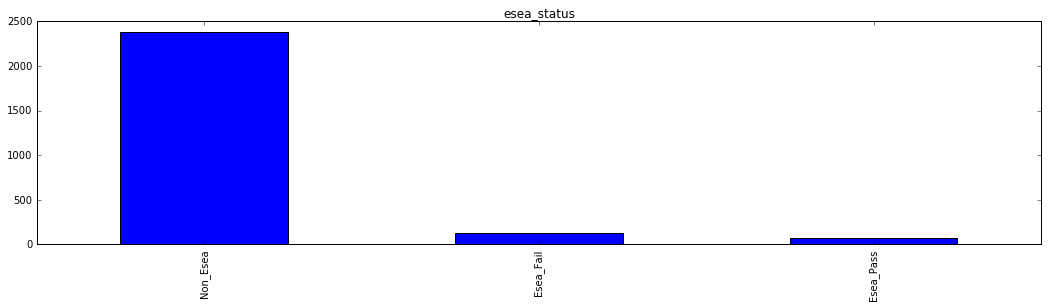

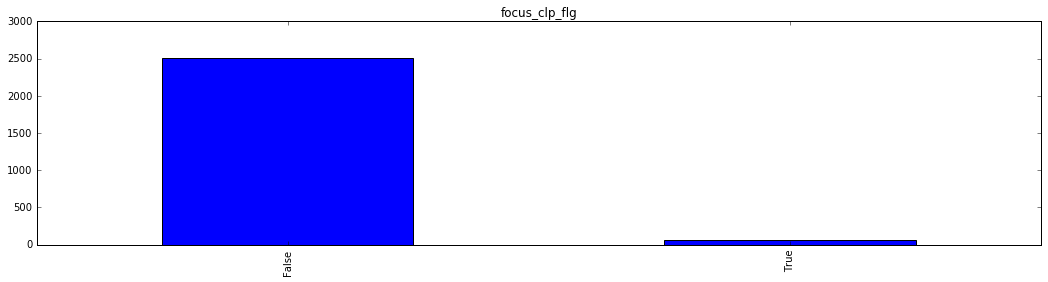

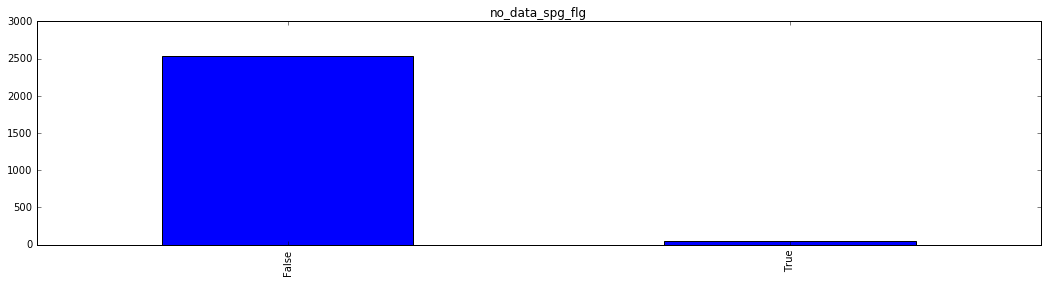

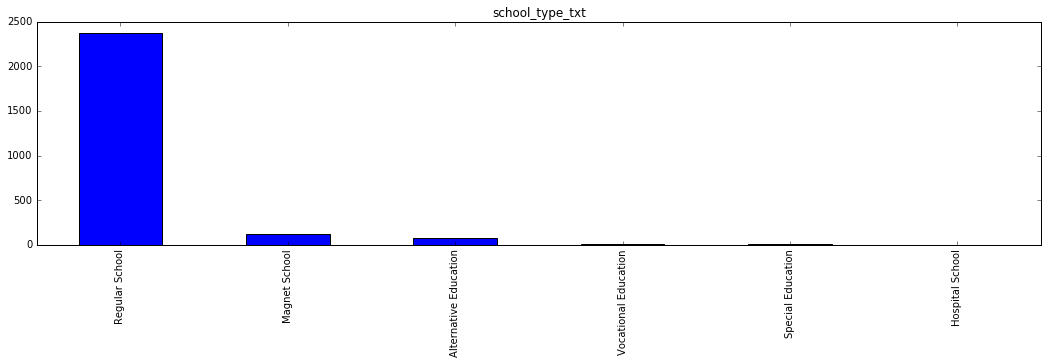

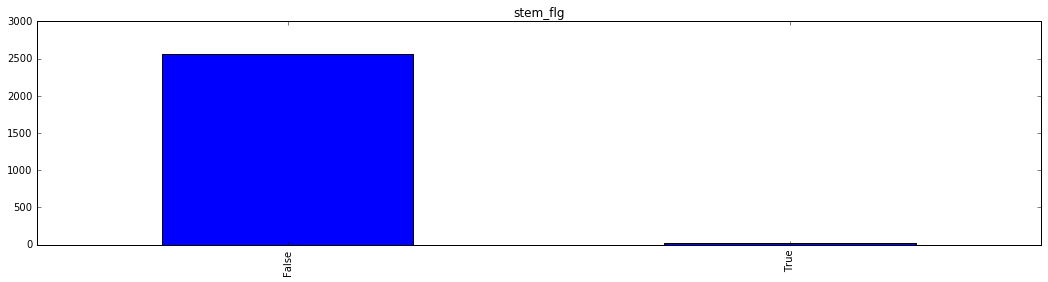

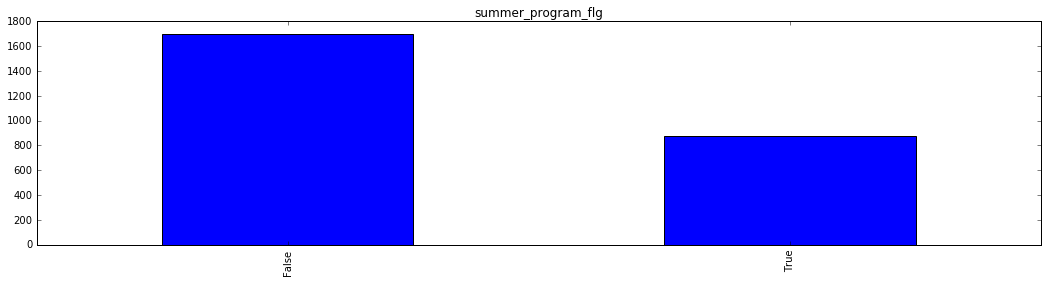

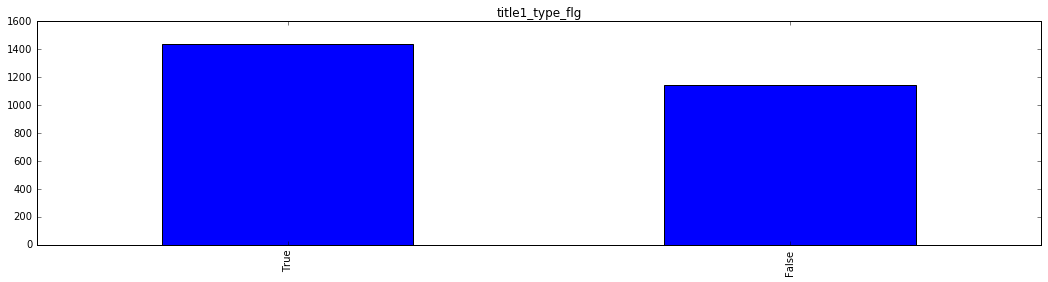

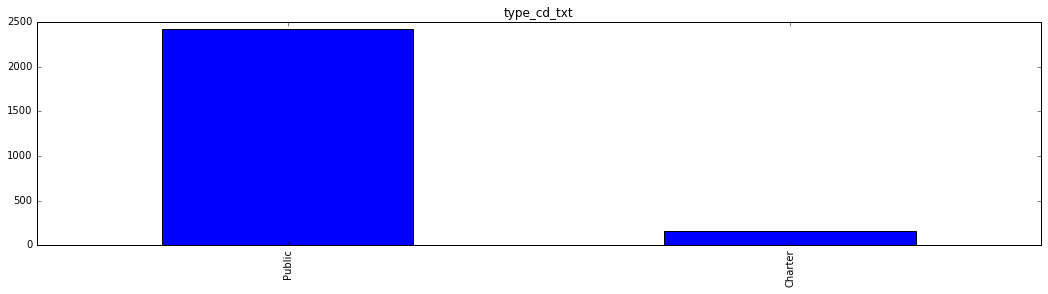

In [66]:
# Examine categorical variables of interest  
import matplotlib.pyplot as plt

for i in range(0,cat_list_obj_len):
    plt.figure(figsize = (18,4))
    ax = schoolData[cat_list_obj[i]].value_counts().plot(kind='bar')
    plt.title(cat_list_obj[i])
    plt.show()

In [72]:
#Get high school campuses reporting overall student numbers 
highSchools = schoolData [((schoolData.category_cd == 'H') | 
                          (schoolData.category_cd == 'T') | 
                          (schoolData.category_cd == 'A'))&
                          (schoolData.student_num > 0) & 
                          (schoolData.type_cd_txt == 'Public') &
                          (schoolData.school_type_txt == 'Regular School')
                         ]
highSchools.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 478 entries, 2 to 2419
Columns: 353 entries, unit_code to Passing_Math_III
dtypes: bool(8), float64(324), int64(8), object(13)
memory usage: 1.3+ MB


In [73]:
#Inspect the high school data fields 
df_temp = highSchools.describe(include='all').T
# include the data type of the column in the dataframe
df_temp['type']= highSchools.dtypes
# Reset the index of the dataframe to have index as numbers to have the number of rows visible in the output
df_temp.reset_index(inplace=True)
df_temp

index count unique                   top freq  \
0                      unit_code   478    478                700319    1   
1                    type_cd_txt   478      1                Public  478   
2                    category_cd   478      3                     H  459   
3                school_type_txt   478      1        Regular School  478   
4              calendar_only_txt   478      2  Traditional Calendar  470   
5                title1_type_flg   478    NaN                   NaN  NaN   
6                    clp_ind_flg   478    NaN                   NaN  NaN   
7                  focus_clp_flg   478    NaN                   NaN  NaN   
8             summer_program_flg   478    NaN                   NaN  NaN   
9                 asm_no_spg_flg   478    NaN                   NaN  NaN   
10               no_data_spg_flg   478    NaN                   NaN  NaN   
11                   esea_status   478      3              Non_Esea  459   
12                   student_num   478    NaN                   NaN  NaN   
13           lea_avg_student_num   478    NaN                   NaN  NaN   
14            st_avg_student_num   478    NaN                   NaN  NaN   
15           Grad_project_status   478    NaN                   NaN  NaN   
16                      stem_flg   478    NaN                   NaN  NaN   
17             Avg_Class_Size_00     2    NaN                   NaN  NaN   
18             Avg_Class_Size_01     3    NaN                   NaN  NaN   
19             Avg_Class_Size_02     3    NaN                   NaN  NaN   
20             Avg_Class_Size_03     3    NaN                   NaN  NaN   
21             Avg_Class_Size_04     3    NaN                   NaN  NaN   
22             Avg_Class_Size_05     3    NaN                   NaN  NaN   
23             Avg_Class_Size_06    12    NaN                   NaN  NaN   
24             Avg_Class_Size_07    13    NaN                   NaN  NaN   
25             Avg_Class_Size_08    13    NaN                   NaN  NaN   
26        Avg_Class_Size_Biology   465    NaN                   NaN  NaN   
27      Avg_Class_Size_EnglishII   466    NaN                   NaN  NaN   
28          Avg_Class_Size_MathI   464    NaN                   NaN  NaN   
29              Avg_Dist_Size_00     2    NaN                   NaN  NaN   
..                           ...   ...    ...                   ...  ...   
323             EOG_Math_Gr5_GLP     3    NaN                   NaN  NaN   
324            EOG_Math_Gr6_CACR    12    NaN                   NaN  NaN   
325             EOG_Math_Gr6_GLP    12    NaN                   NaN  NaN   
326            EOG_Math_Gr7_CACR    14    NaN                   NaN  NaN   
327             EOG_Math_Gr7_GLP    14    NaN                   NaN  NaN   
328            EOG_Math_Gr8_CACR    14    NaN                   NaN  NaN   
329             EOG_Math_Gr8_GLP    14    NaN                   NaN  NaN   
330           EOG_Reading_G3_GLP     3    NaN                   NaN  NaN   
331         EOG_Reading_Gr3_CACR     3    NaN                   NaN  NaN   
332         EOG_Reading_Gr4_CACR     3    NaN                   NaN  NaN   
333          EOG_Reading_Gr4_GLP     3    NaN                   NaN  NaN   
334         EOG_Reading_Gr5_CACR     3    NaN                   NaN  NaN   
335          EOG_Reading_Gr5_GLP     3    NaN                   NaN  NaN   
336         EOG_Reading_Gr6_CACR    12    NaN                   NaN  NaN   
337          EOG_Reading_Gr6_GLP    12    NaN                   NaN  NaN   
338         EOG_Reading_Gr7_CACR    14    NaN                   NaN  NaN   
339          EOG_Reading_Gr7_GLP    14    NaN                   NaN  NaN   
340         EOG_Reading_Gr8_CACR    14    NaN                   NaN  NaN   
341          EOG_Reading_Gr8_GLP    14    NaN                   NaN  NaN   
342  EOG_Reading_Grades_3_8_CACR    16    NaN                   NaN  NaN   
343   EOG_Reading_Grades_3_8_GLP    16    NaN                   NaN  NaN   

In [74]:
#List of all int32 fields
int32Fields = ['student_num', 'lea_avg_student_num','Avg_Class_Size_00','Avg_Class_Size_01',
             'Avg_Class_Size_02','Avg_Class_Size_03','Avg_Class_Size_04','Avg_Class_Size_05',
             'Avg_Class_Size_06','Avg_Class_Size_07','Avg_Class_Size_08','Avg_Class_Size_Biology',
             'Avg_Class_Size_EnglishII','Avg_Class_Size_MathI','Avg_Dist_Size_00','Avg_Dist_Size_01',
             'Avg_Dist_Size_02','Avg_Dist_Size_03','Avg_Dist_Size_04','Avg_Dist_Size_05','Avg_Dist_Size_06',
             'Avg_Dist_Size_07','Avg_Dist_Size_08','Avg_Dist_Size_Biology','Avg_Dist_Size_EnglishII',
             'Avg_State_Size_04','Avg_State_Size_05','Avg_State_Size_06','Avg_State_Size_07','Avg_State_Size_08',
             'Avg_State_Size_Biology','Avg_State_Size_EnglishII','Avg_State_Size_MathI','SPG Score','Reading  SPG Score',
             'Math SPG Score','Overall Achievement Score','Read Score','Math Score','Science Score','Math I Score',
             'English II Score','Biology Score','The ACT Score','ACT WorkKeys Score','Math Course Rigor Score',
             'Cohort Graduation Rate Standard Score','sat_avg_score_num','lea_sat_avg_score_num','st_sat_avg_score_num',
             'nat_sat_avg_score_num','avg_age_media_collection','lea_avg_age_media_collection','st_avg_age_media_collection',
             'wap_num','lea_wap_num','st_wap_num','class_teach_num','nbpts_num','lea_class_teach_num','lea_nbpts_num',
             'st_class_teach_num','st_nbpts_num']

#Cannot convert from float64 to int32 due to missing values, should revisit this 
#highSchools[int32Fields] = highSchools[int32Fields].apply(np.int32, axis=1)

In [75]:
#Look at missing / NaN values by column
for col in highSchools:
    x = highSchools[col].value_counts(dropna=False)
    print(x)
    print('***************************************************')

700319    1
130333    1
110352    1
490310    1
350308    1
920441    1
860336    1
640350    1
980336    1
422315    1
960700    1
422310    1
182700    1
130332    1
510324    1
410508    1
510327    1
570317    1
100334    1
410595    1
190342    1
760388    1
570318    1
700317    1
600426    1
120318    1
410556    1
940316    1
500302    1
040700    1
         ..
260357    1
900311    1
100307    1
580368    1
990304    1
360337    1
360336    1
010360    1
132304    1
240334    1
410355    1
510357    1
840302    1
340382    1
110304    1
490320    1
340454    1
761304    1
920588    1
900377    1
410562    1
920582    1
292324    1
920581    1
920586    1
410569    1
920585    1
180376    1
410408    1
390704    1
Name: unit_code, dtype: int64
***************************************************
Public    478
Name: type_cd_txt, dtype: int64
***************************************************
H    459
T     15
A      4
Name: category_cd, dtype: int64
*****************************